In [1]:
import os
import pickle

import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from policy import config
from policy.dataset.ms2dataset import get_MS_loaders
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/024"

cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)

index_path = os.path.join(model_dir, "data_info.pickle")
with open(index_path, 'rb') as f:
    data_info = pickle.load(f)

# Dataset
cfg["data"]["pad_train"] = False
cfg["data"]["pad_val"] = False
cfg["data"]["augment"] = True
cfg["data"]["augmentation"]["image_aug"] = .5
cfg["data"]["augmentation"]["input_noise"] = False
cfg["data"]["full_seq"] = False

# Load only the full episode version of the dataset
if "train_ep_indices" not in data_info.keys():
    train_idx, val_idx = data_info["train_indices"], data_info["val_indices"]
else:
    train_idx, val_idx = data_info["train_ep_indices"], data_info["val_ep_indices"]
train_dataset, val_dataset = get_MS_loaders(cfg, return_datasets=True, 
                                            indices=(train_idx, val_idx),
                                            save_override=True)

Found existing data info file
Using override indices
Loading action and state scaling from file


/tmp/ipykernel_2083767/3436574841.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(im)


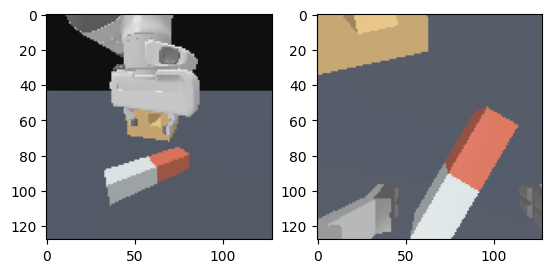

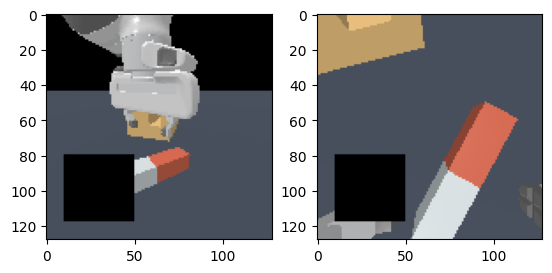

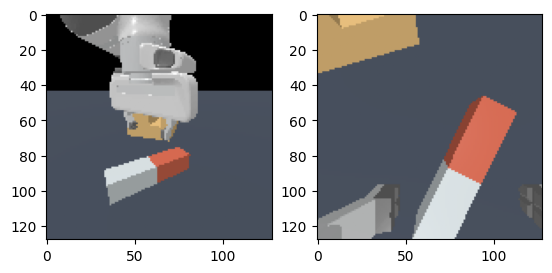

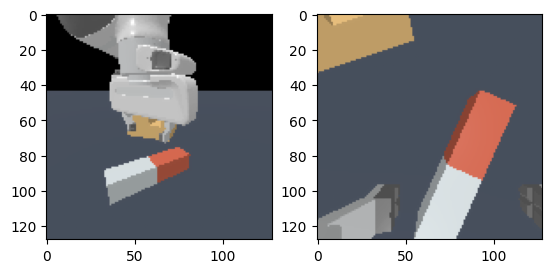

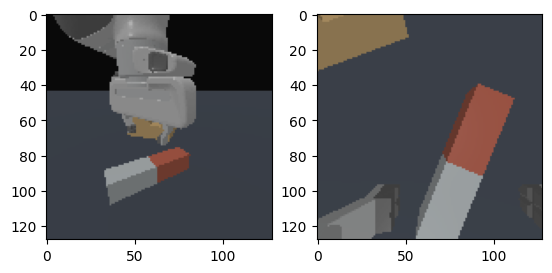

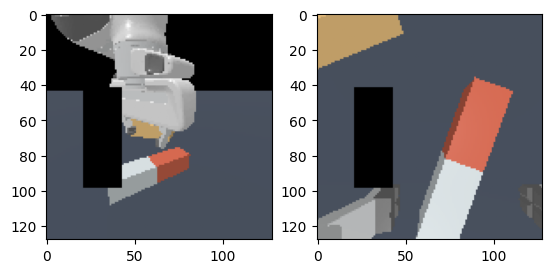

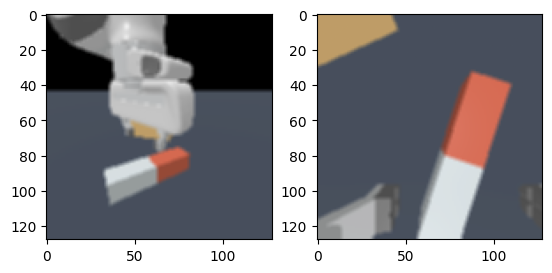

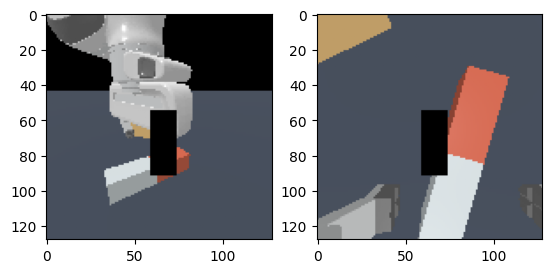

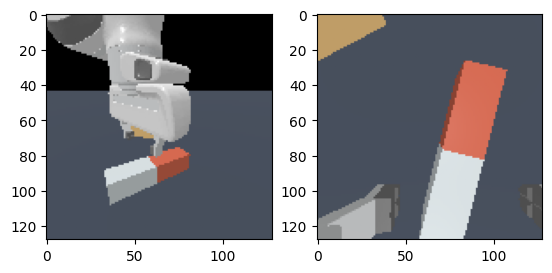

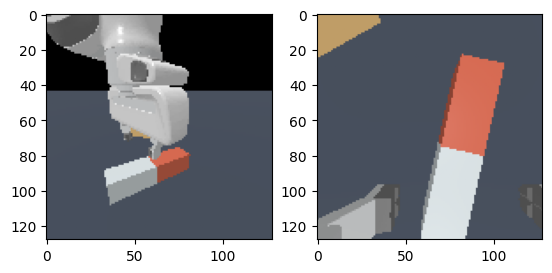

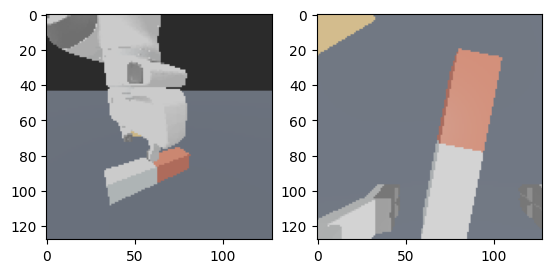

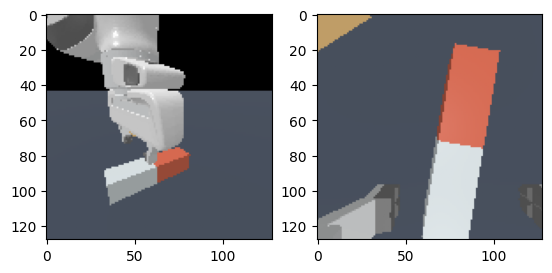

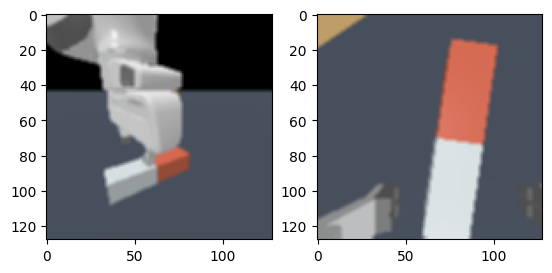

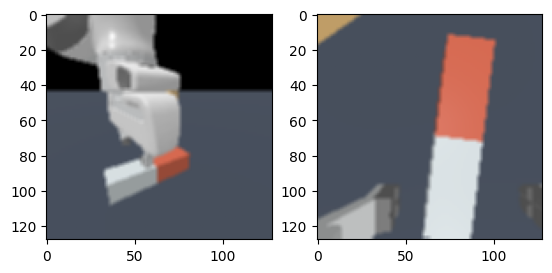

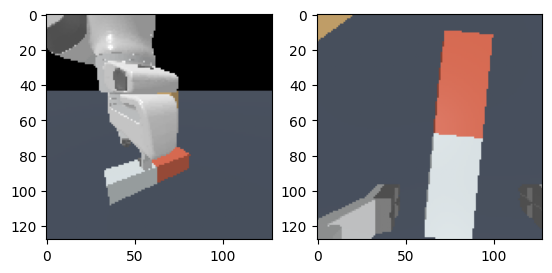

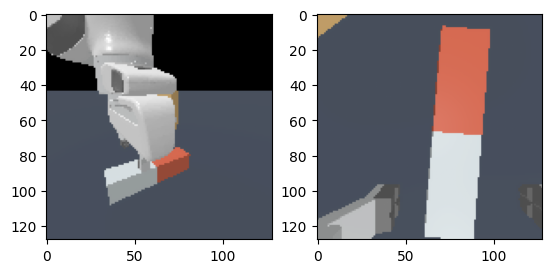

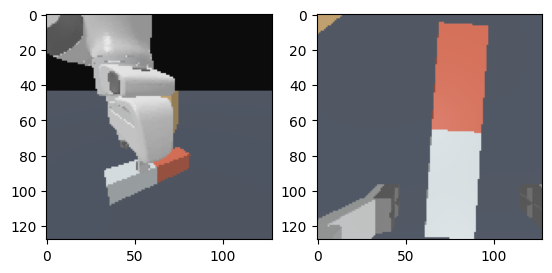

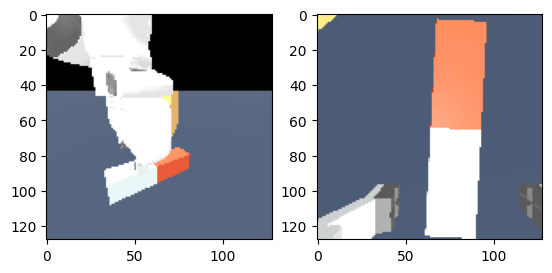

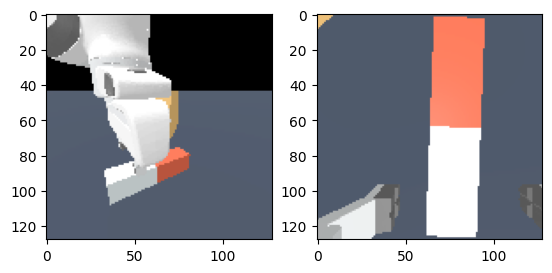

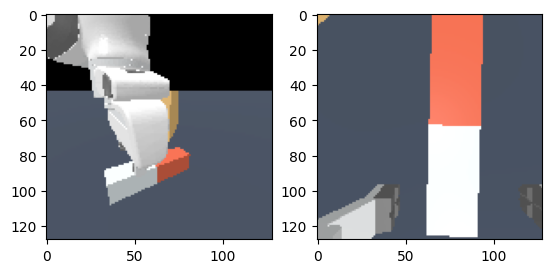

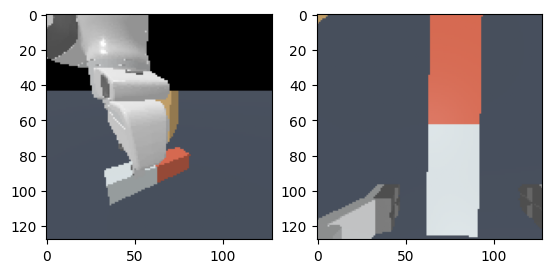

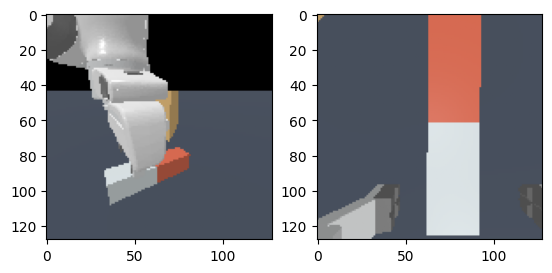

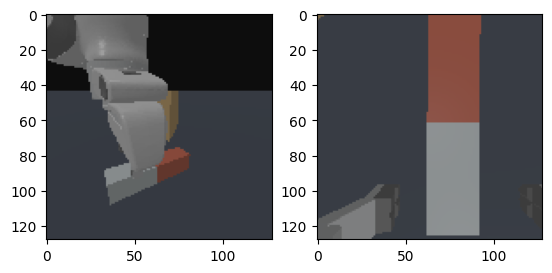

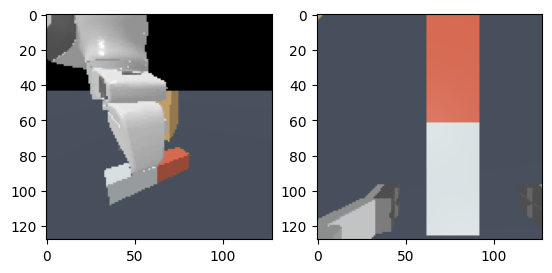

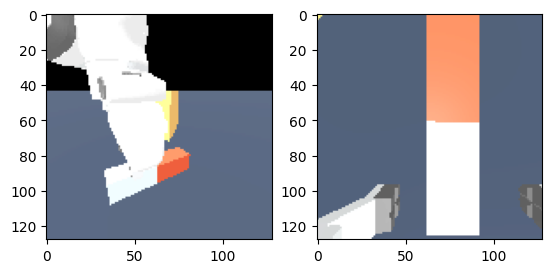

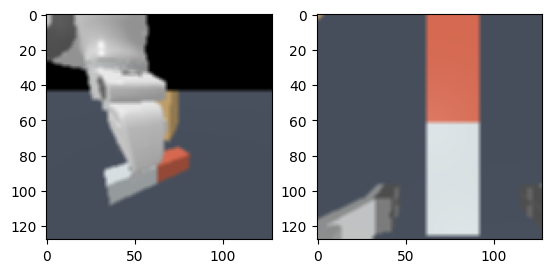

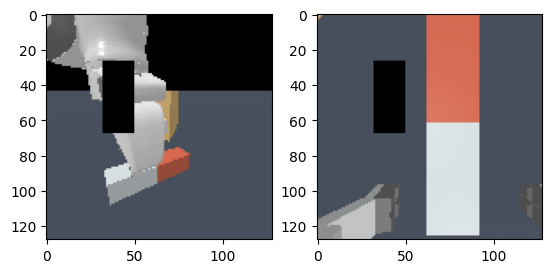

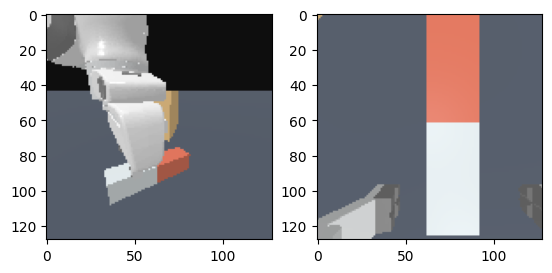

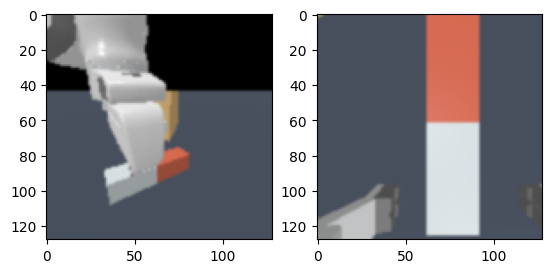

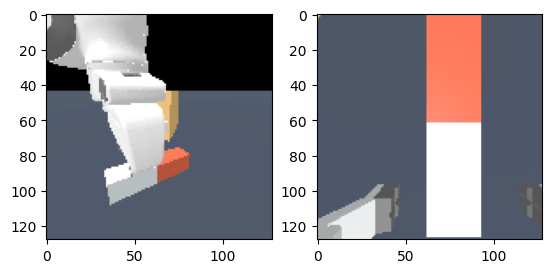

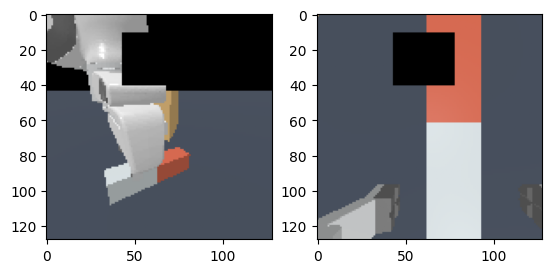

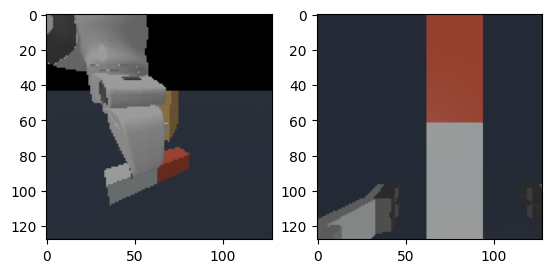

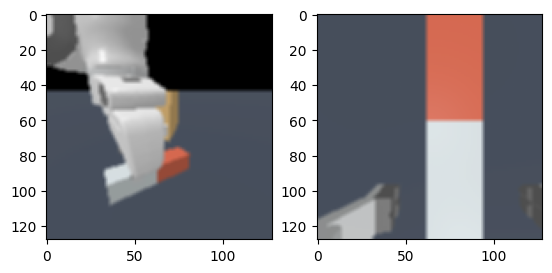

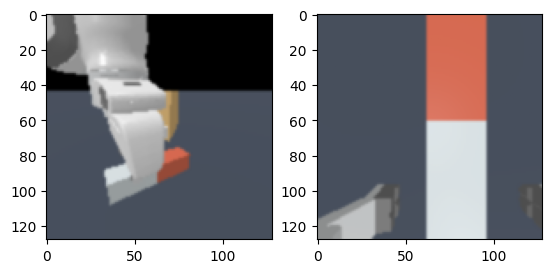

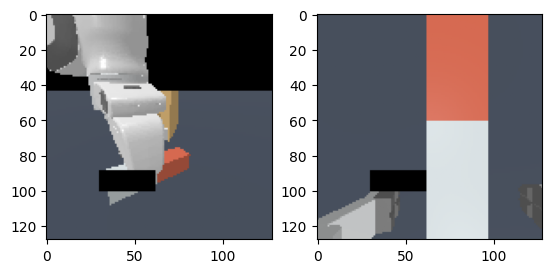

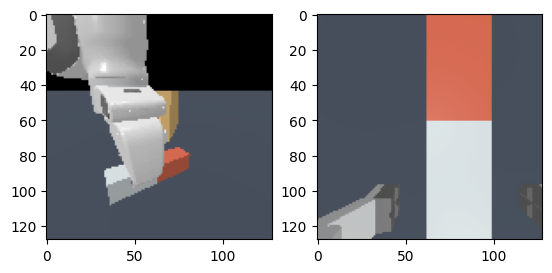

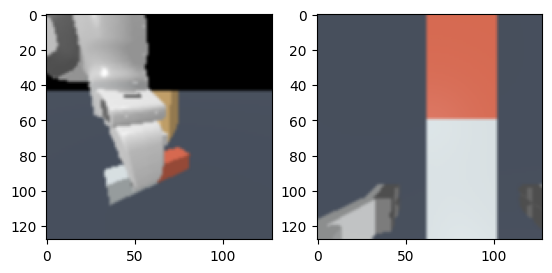

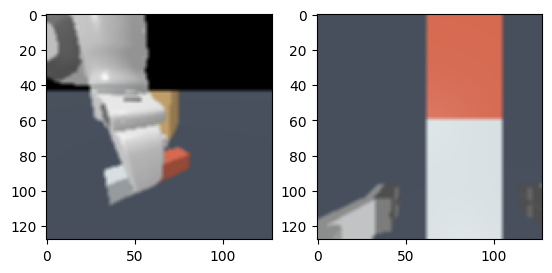

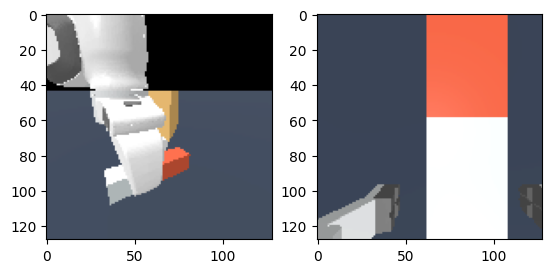

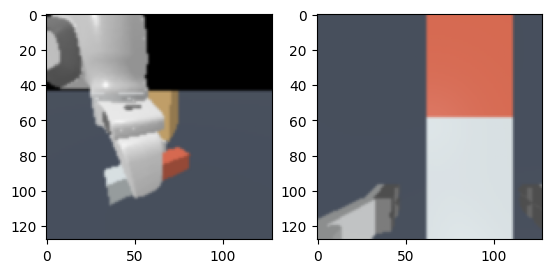

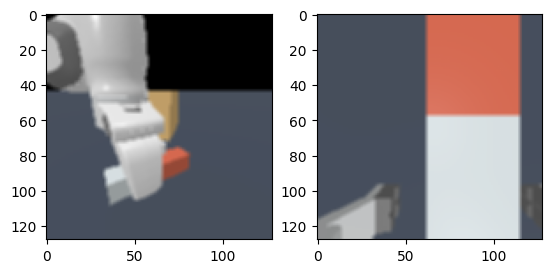

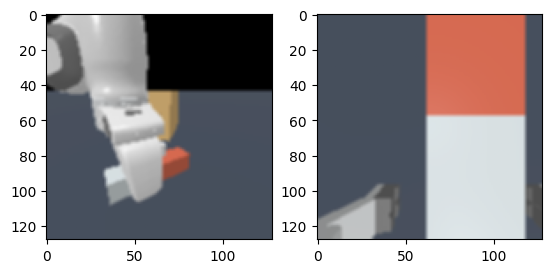

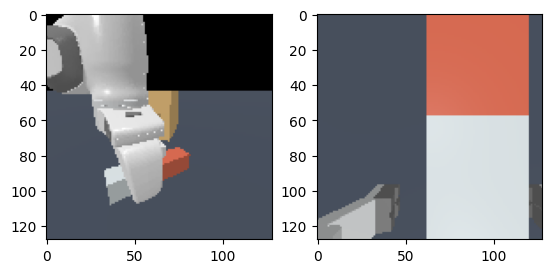

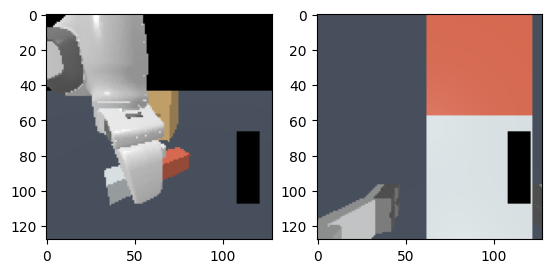

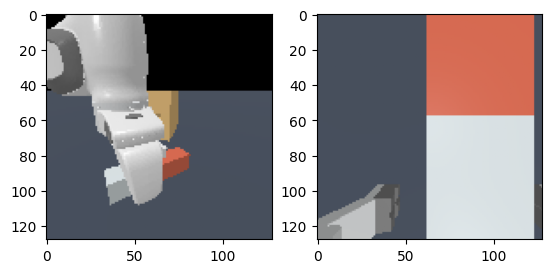

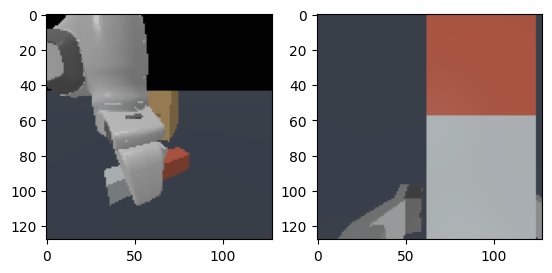

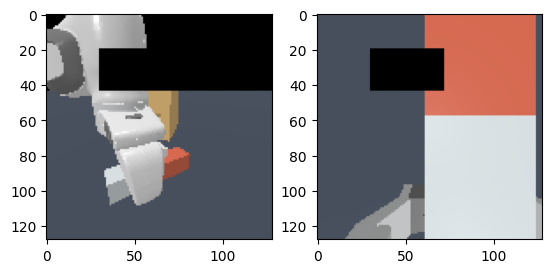

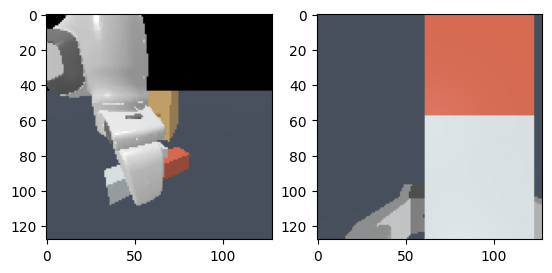

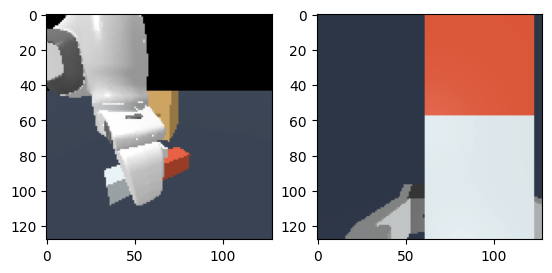

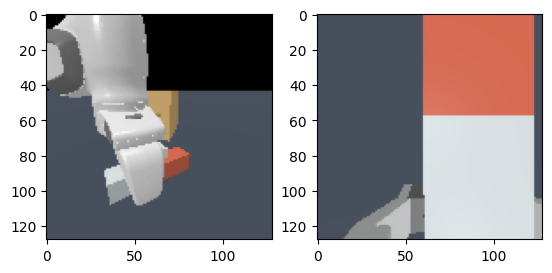

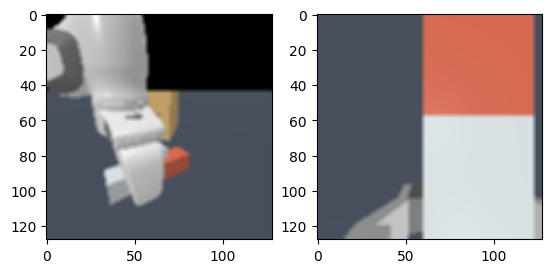

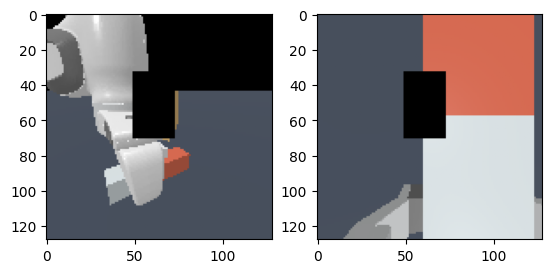

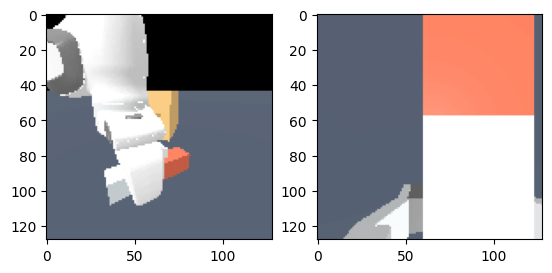

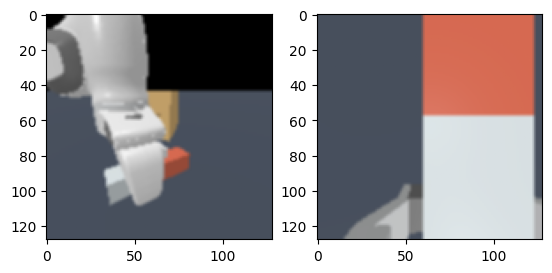

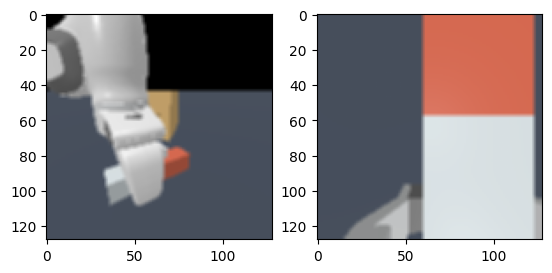

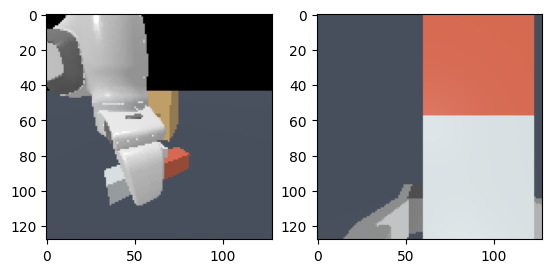

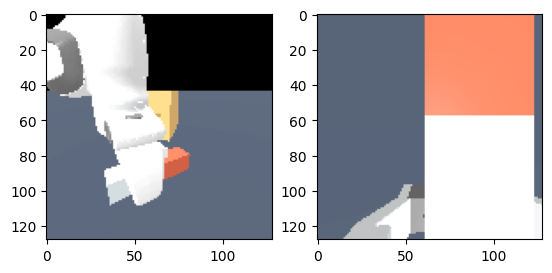

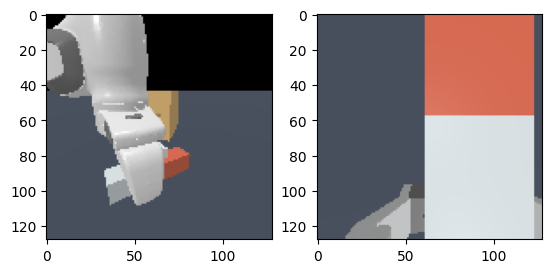

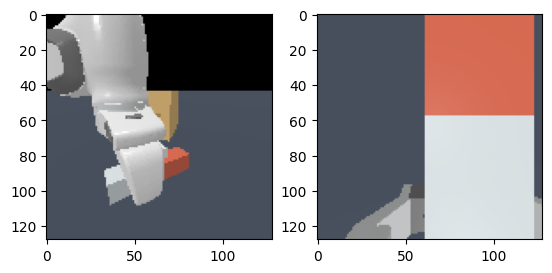

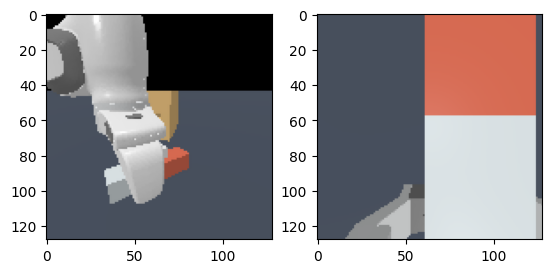

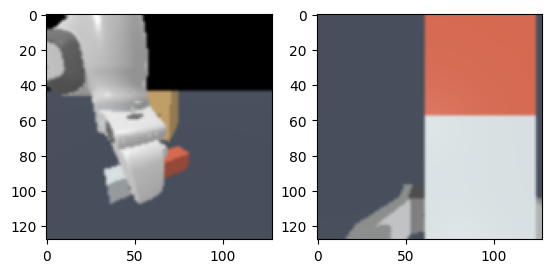

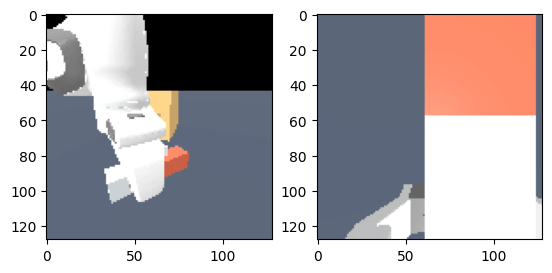

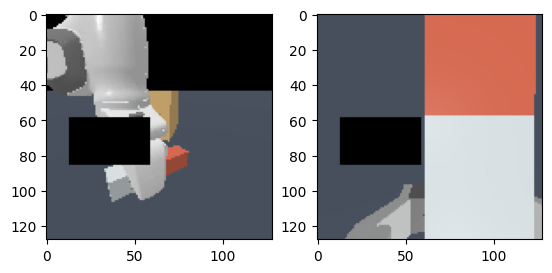

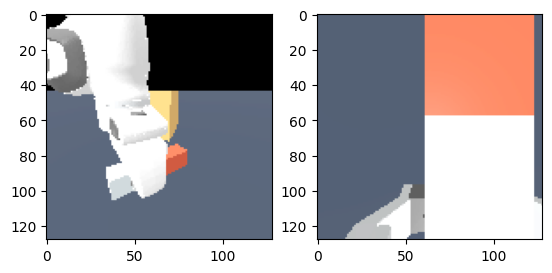

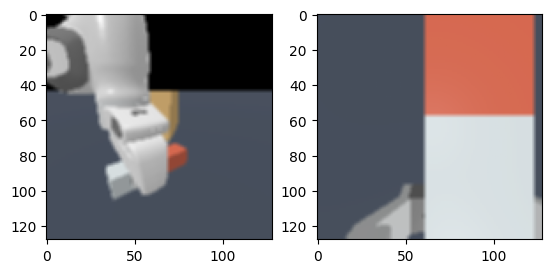

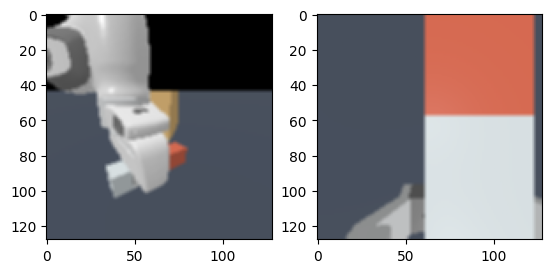

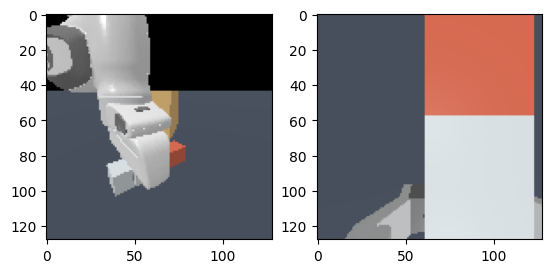

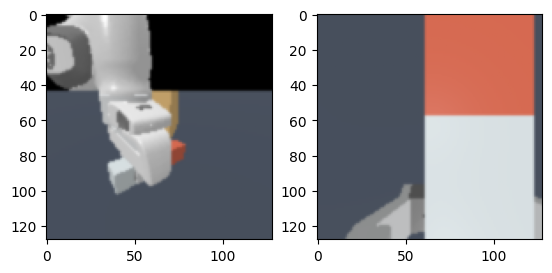

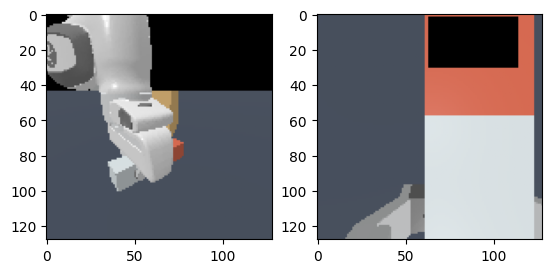

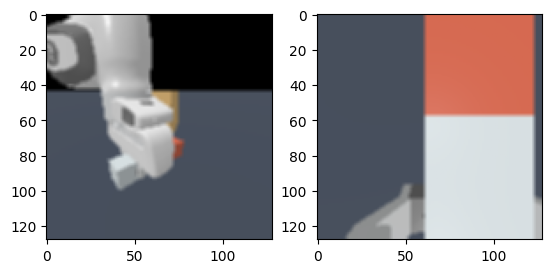

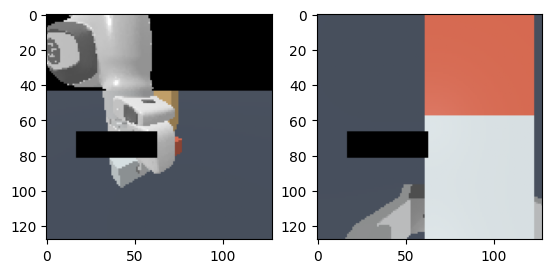

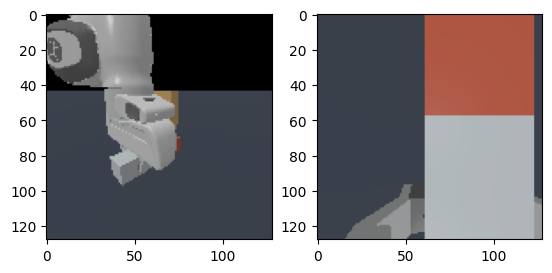

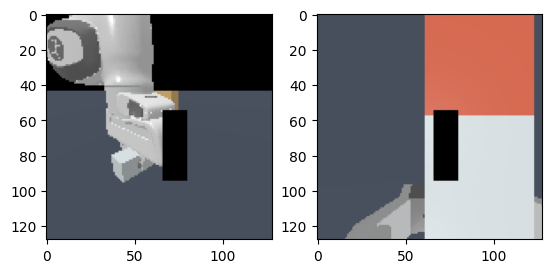

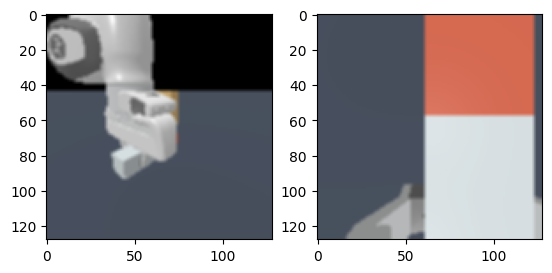

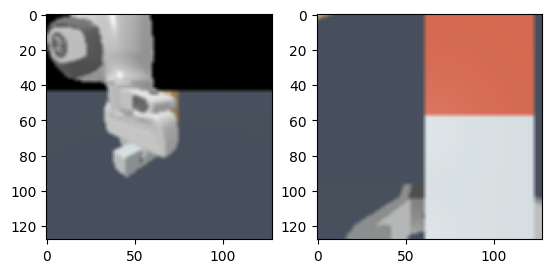

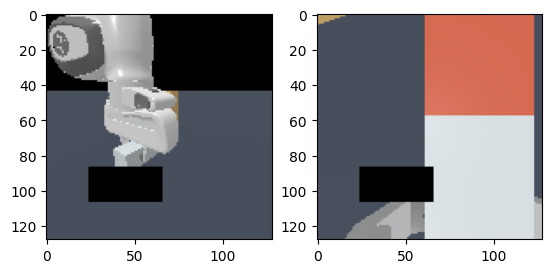

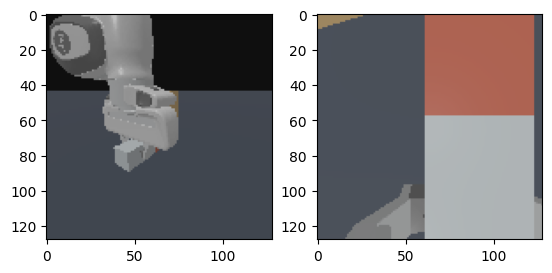

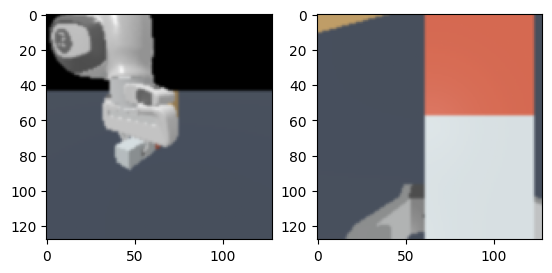

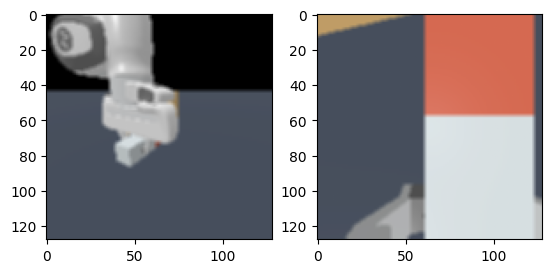

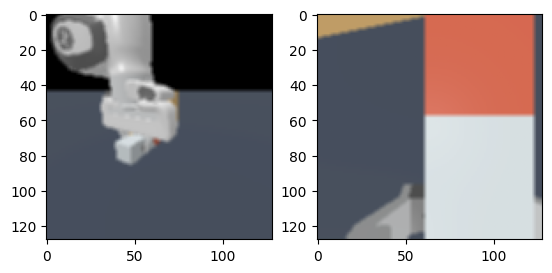

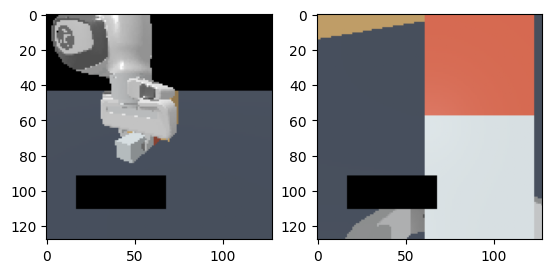

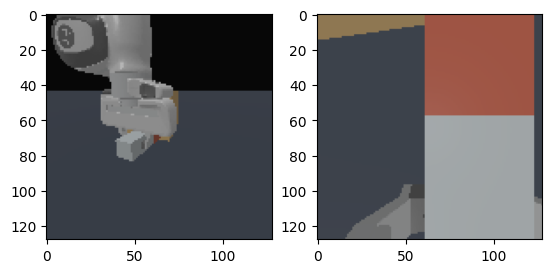

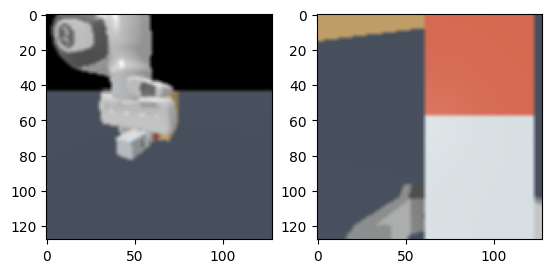

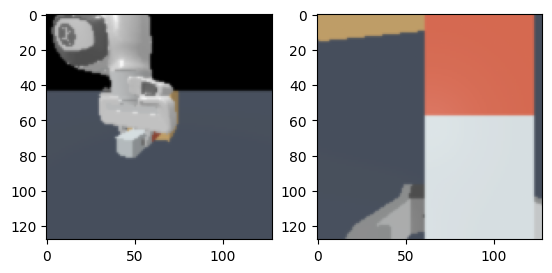

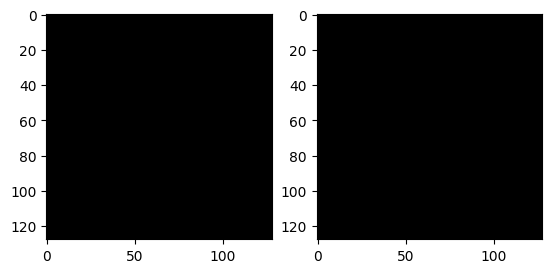

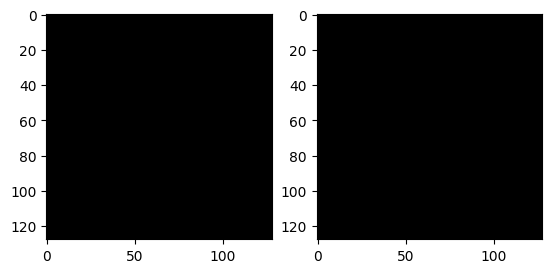

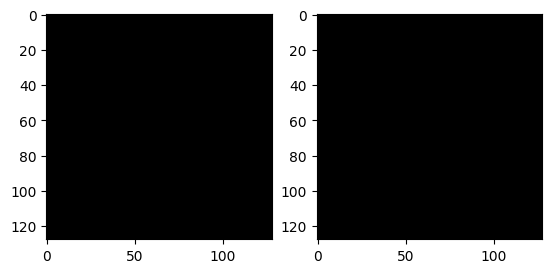

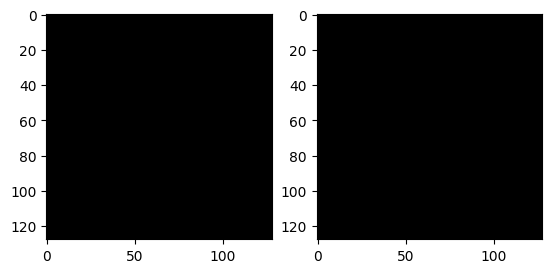

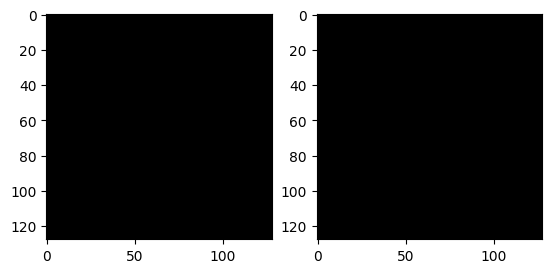

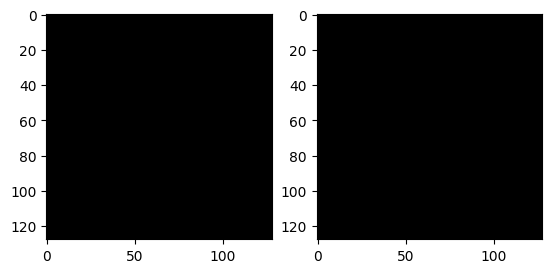

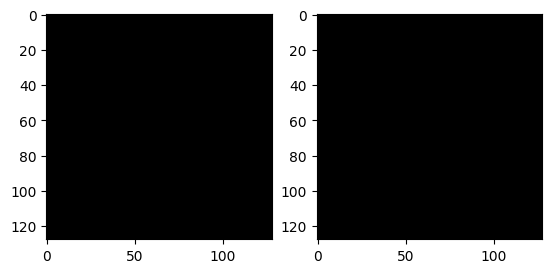

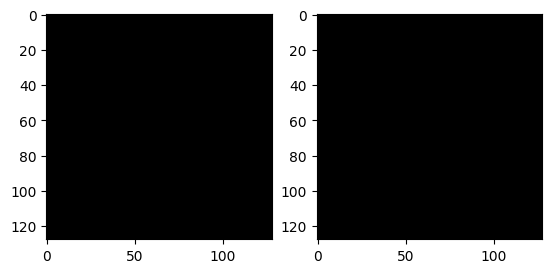

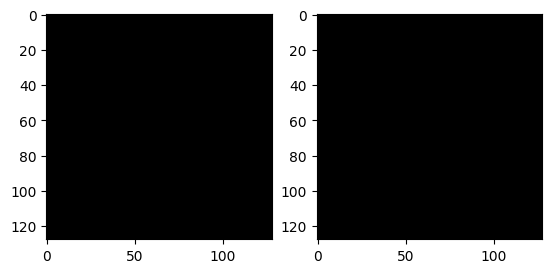

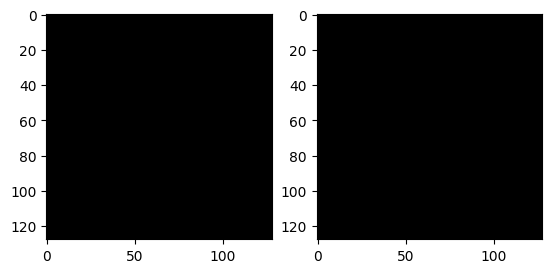

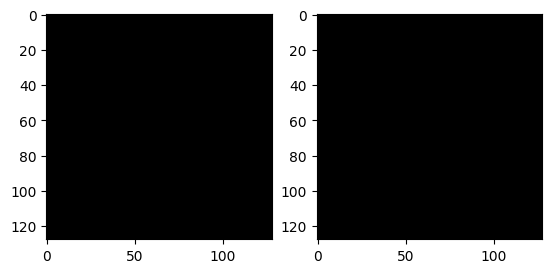

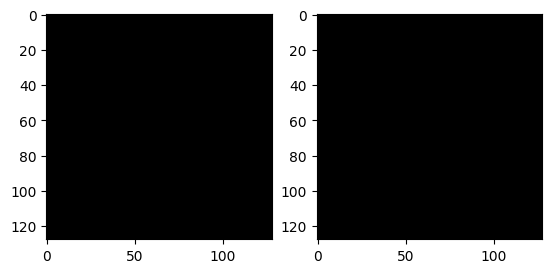

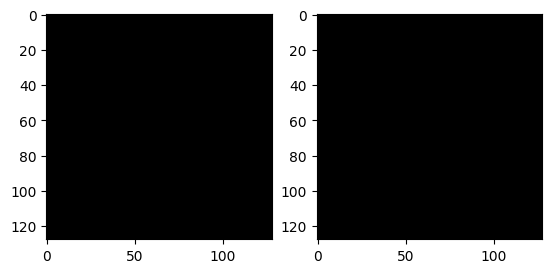

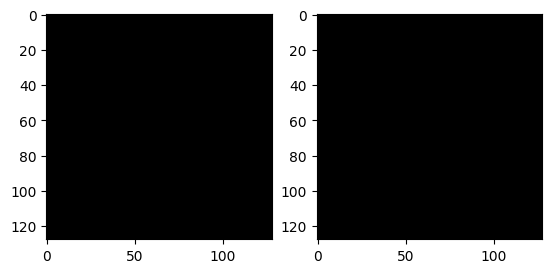

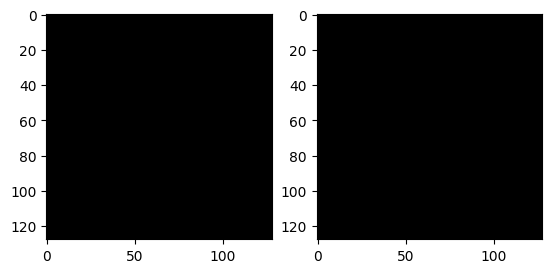

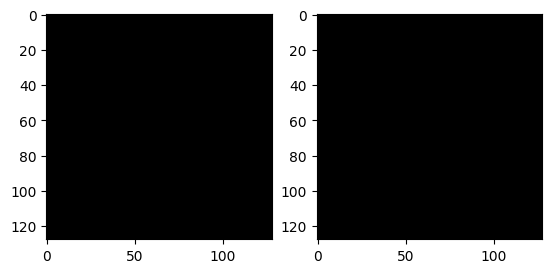

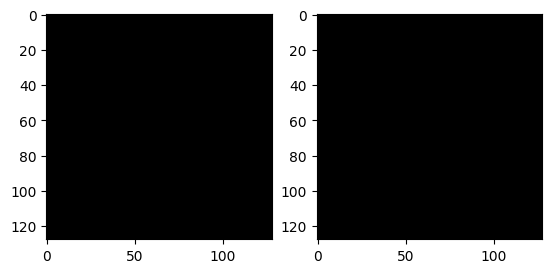

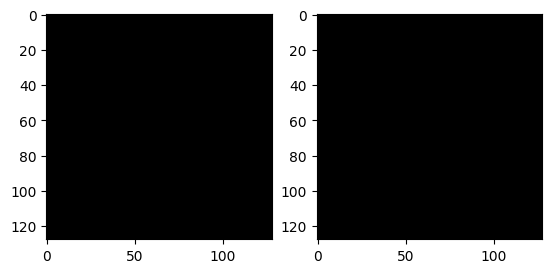

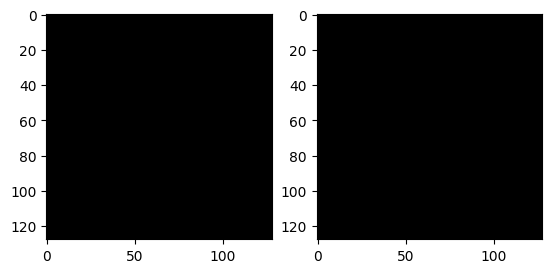

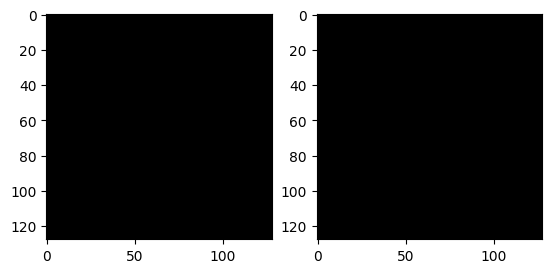

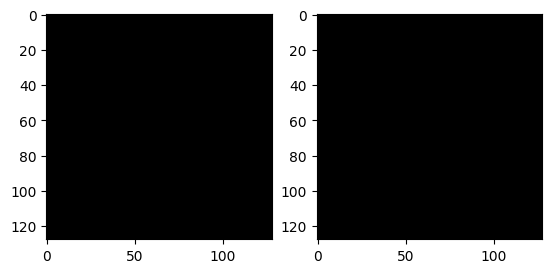

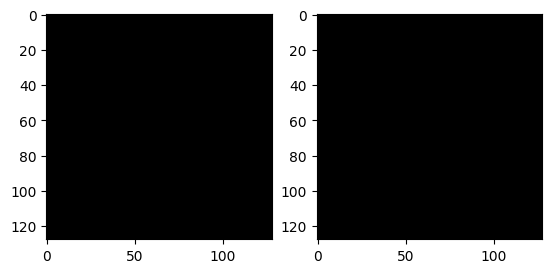

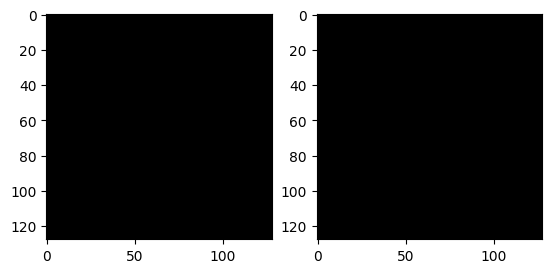

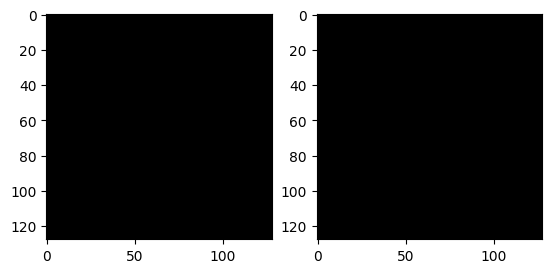

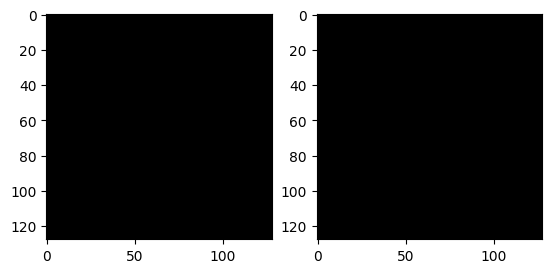

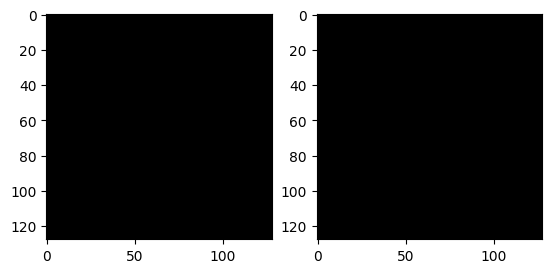

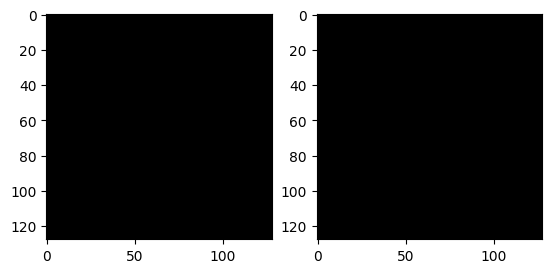

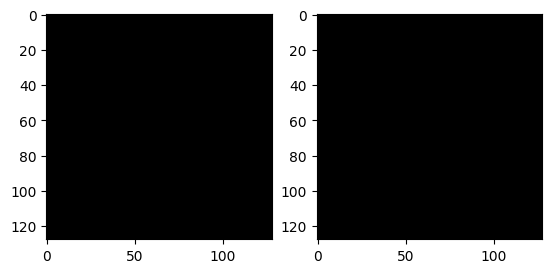

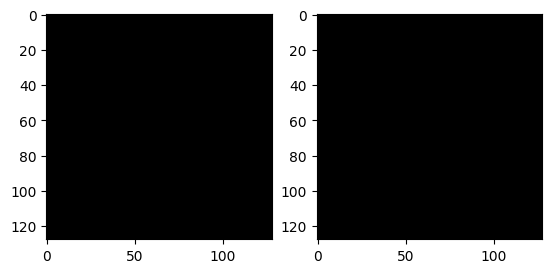

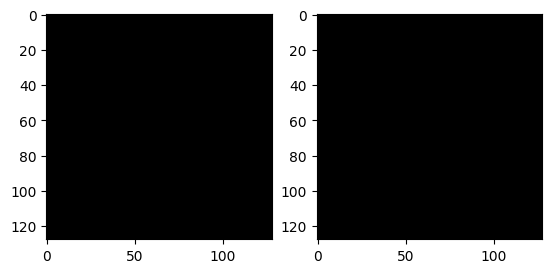

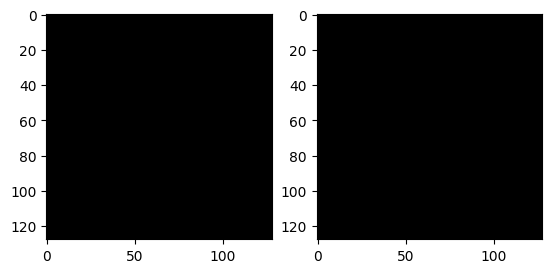

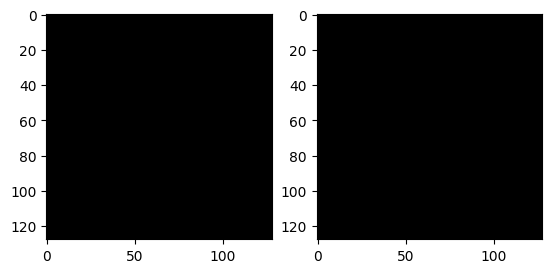

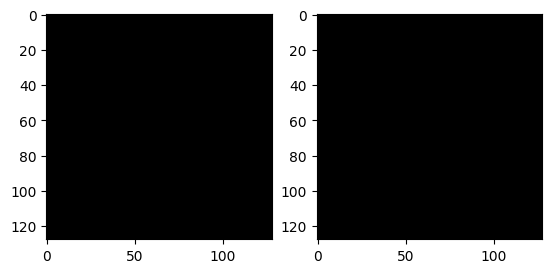

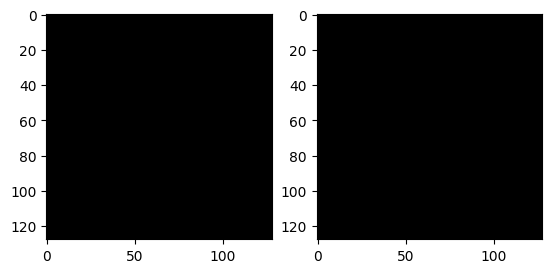

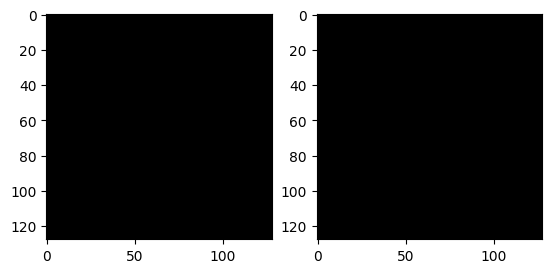

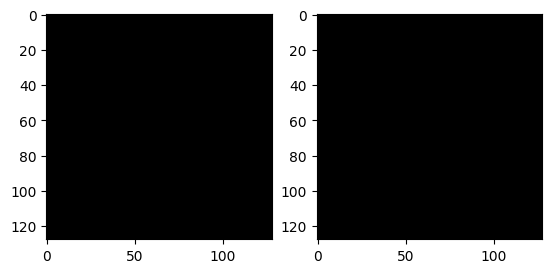

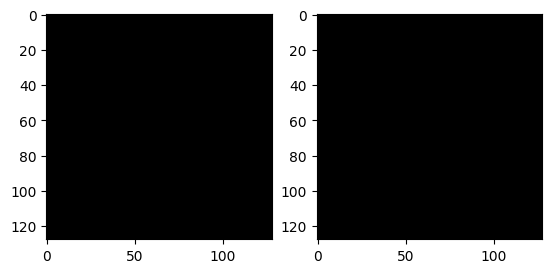

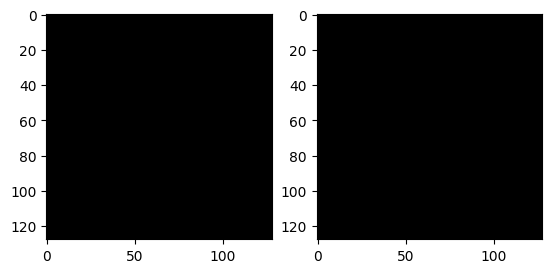

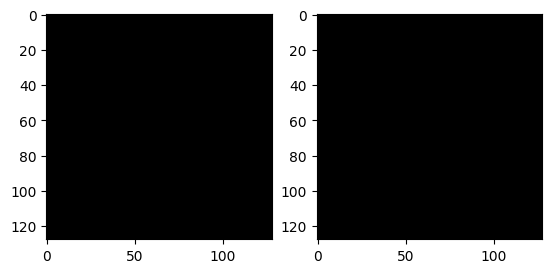

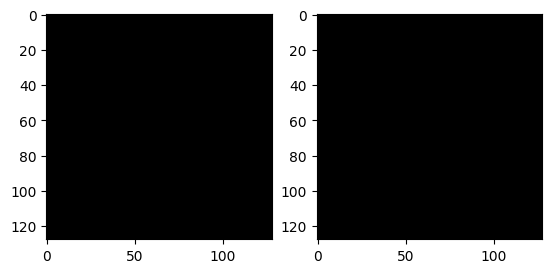

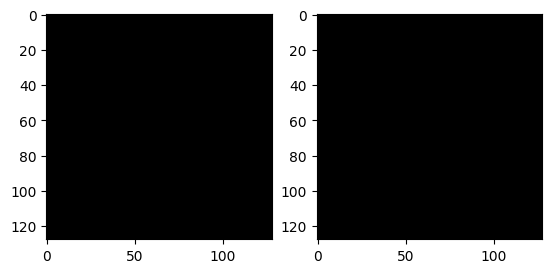

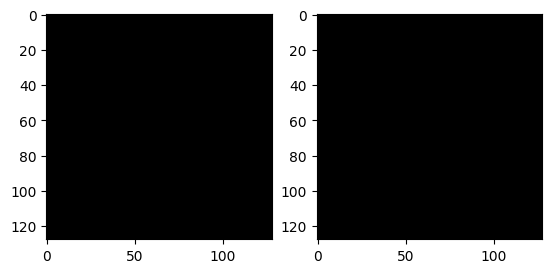

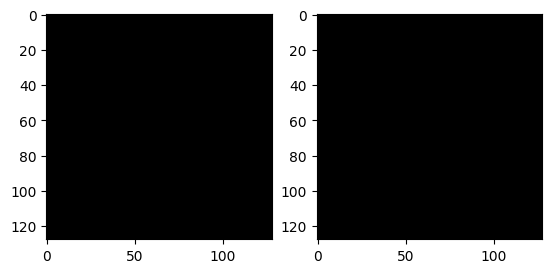

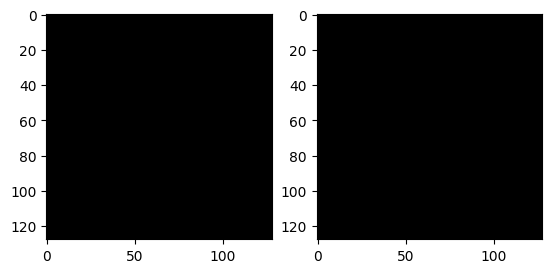

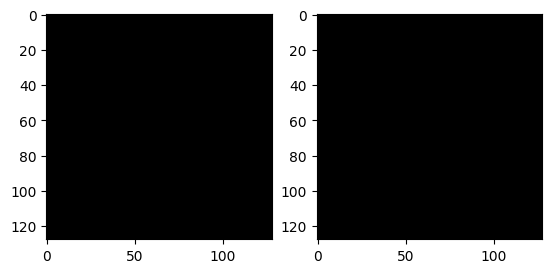

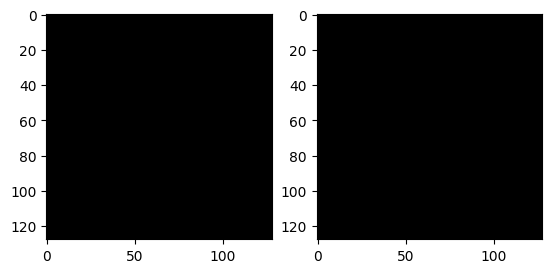

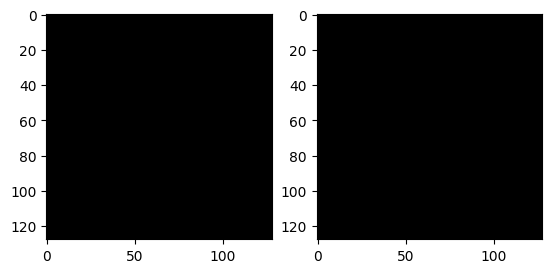

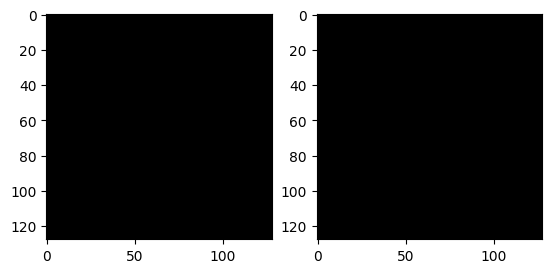

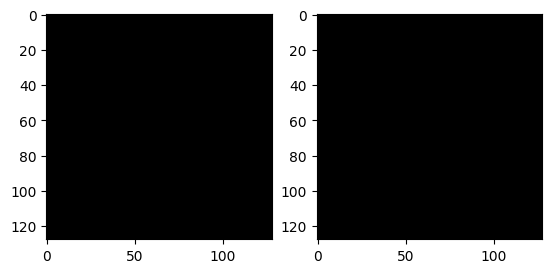

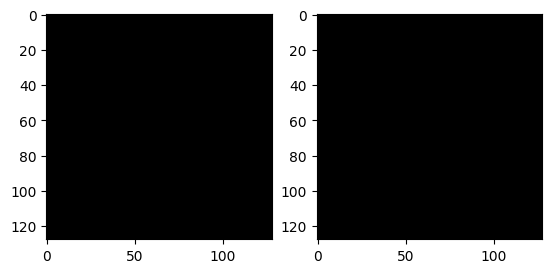

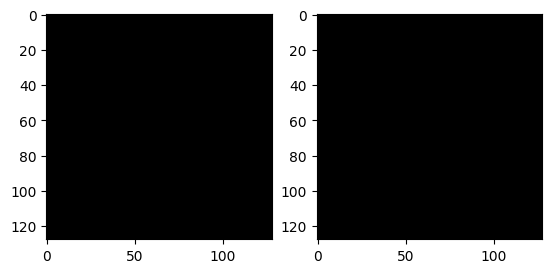

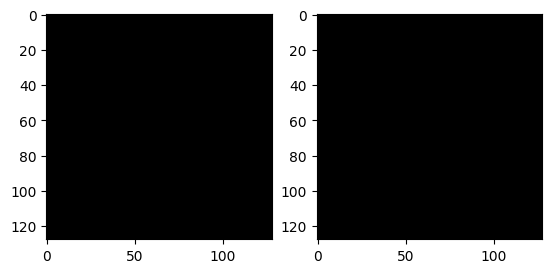

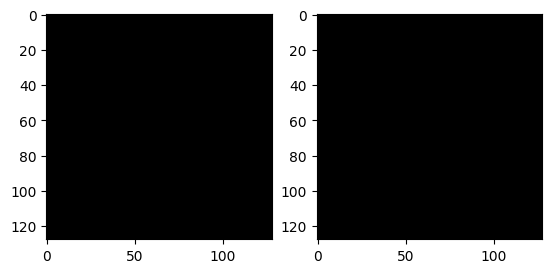

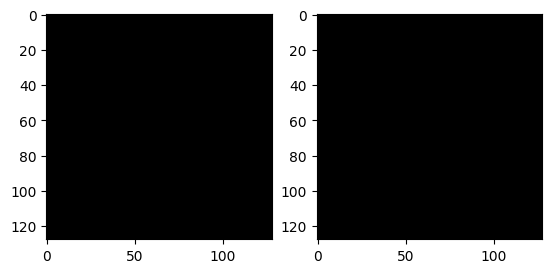

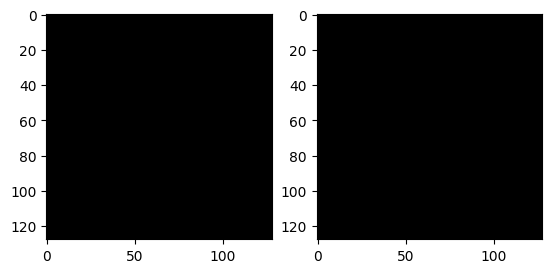

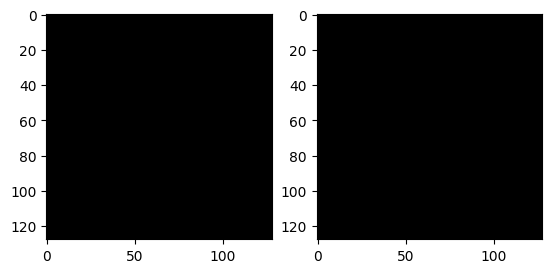

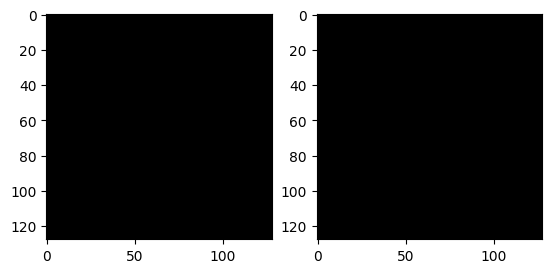

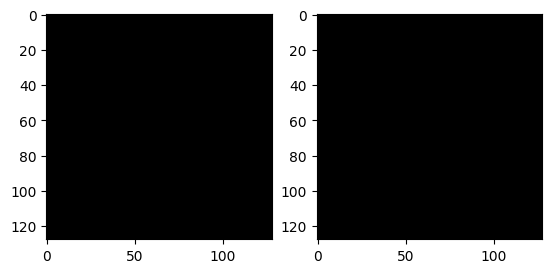

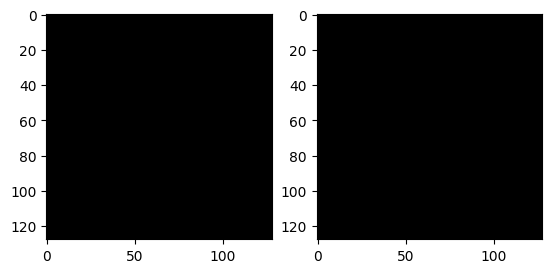

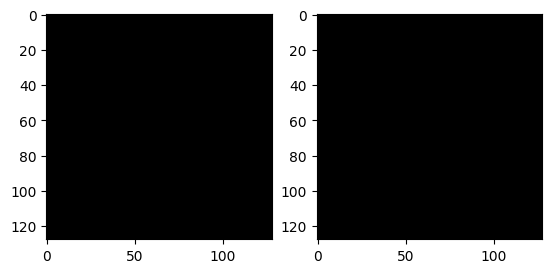

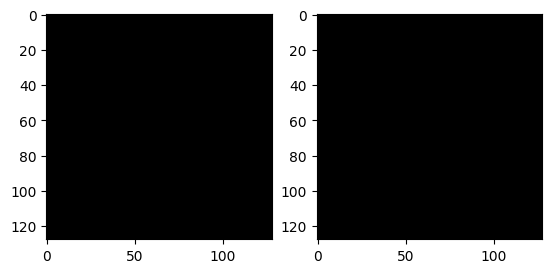

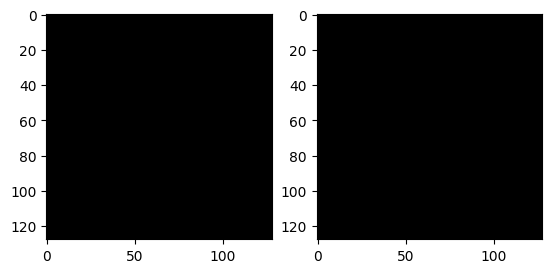

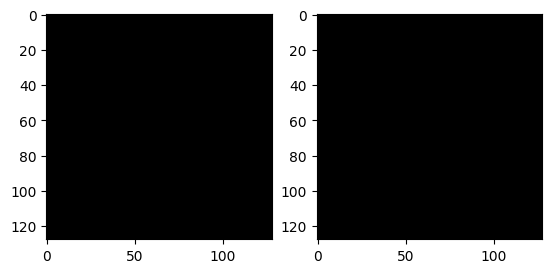

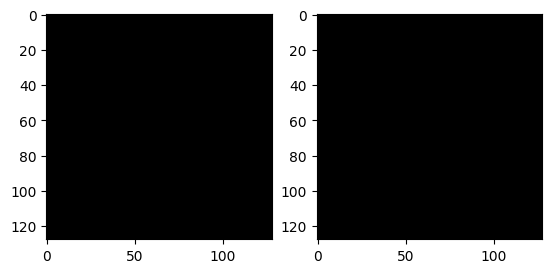

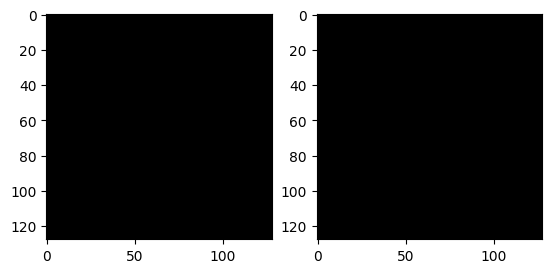

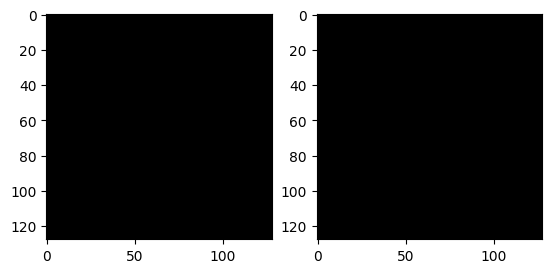

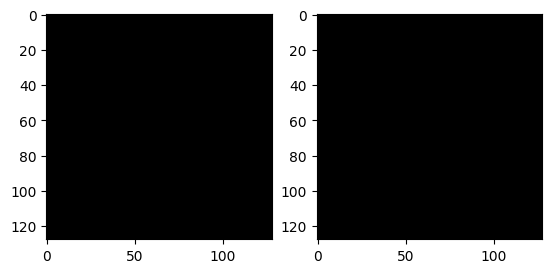

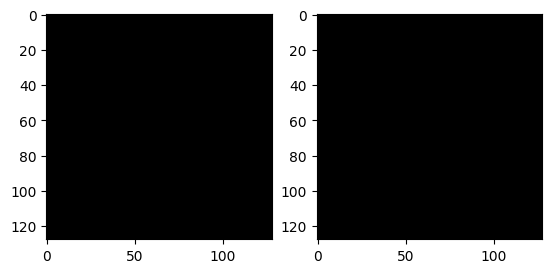

In [2]:
plt.close()
i = 1
data = train_dataset[i]
n = data["rgb"].shape[1]
for im in range(n):
    fig = plt.figure(im)
    ax1, ax2 = fig.subplots(1,2)
    ax1.imshow(data["rgb"][0,im,0,...].permute(1,2,0))
    ax2.imshow(data["rgb"][0,im,1,...].permute(1,2,0))